В задании стоит задача бинарной классификации. В качестве оценивающей метрики была взята метрика AUC. Были испробованы 4 алгоритма: XGB, Random forest, cart и Logistic regression.
После применения каждого алгоритма выводится его точность на обучающей и тестовой выборках.

In [1]:
library(gdata)
library(caret)
library(xgboost)
library(rpart)
library(randomForest)
library(glmnet)
library(ROCR)
library(MLmetrics)
library(classifierplots)
library(corrplot)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: lattice
Loading required package: ggplot2
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:gdata’:

    combine

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘MLmetrics’

The following object is masked from ‘package:base’:

    Recall

Loading re

Загрузка данных

In [2]:
X = read.csv('features.csv', sep=';', dec=',')
y = read.csv('target.csv', header=F)
y = as.matrix(y)

Распределение классов неравномерное, поэтому метрка Accuracy не подходит

In [3]:
table(y)[1] / sum(table(y))

0 
0.7118115

In [4]:
dummy = model.matrix(~X[,6])
X = transform(X, X6 = dummy[, 2])
#X = as.matrix(X)
y = as.numeric(y)
X_raw = X

In [5]:
correlation_X = cor(X)

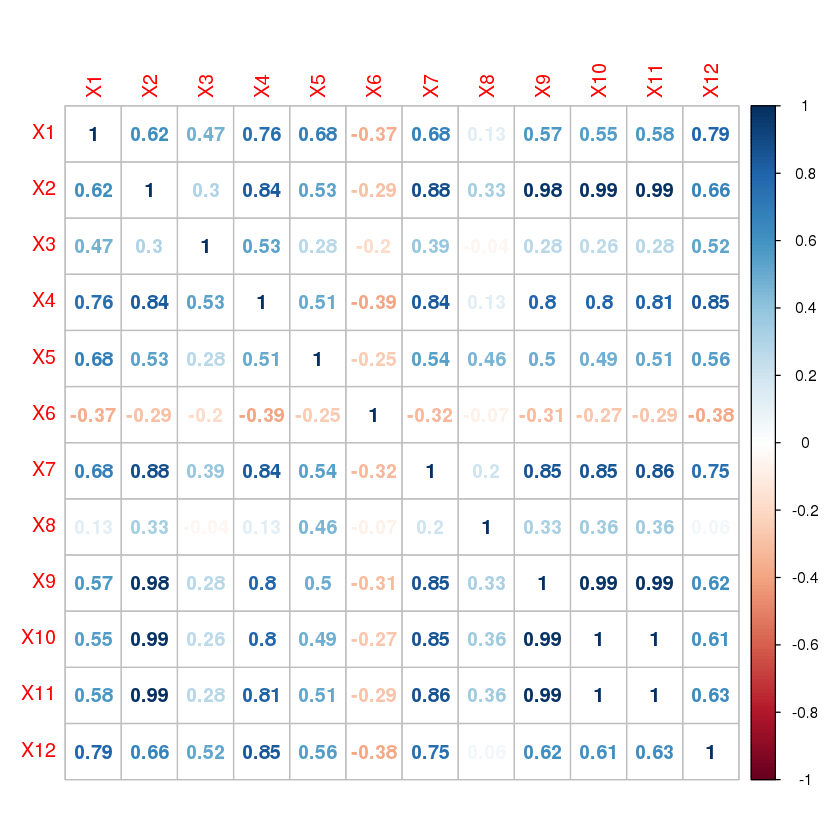

In [6]:
corrplot(correlation_X, method="number")

Посмотрев в матрицу корреляции, можно замеить, что некоторые признаки сильно коррелируют между собой, поэтому не несут никакой пользы. Их можно удалить.

Так же можно поэксперементировать и попробовать вывести новые признаки, которые будут хорошо коррелировать с целевой переменной

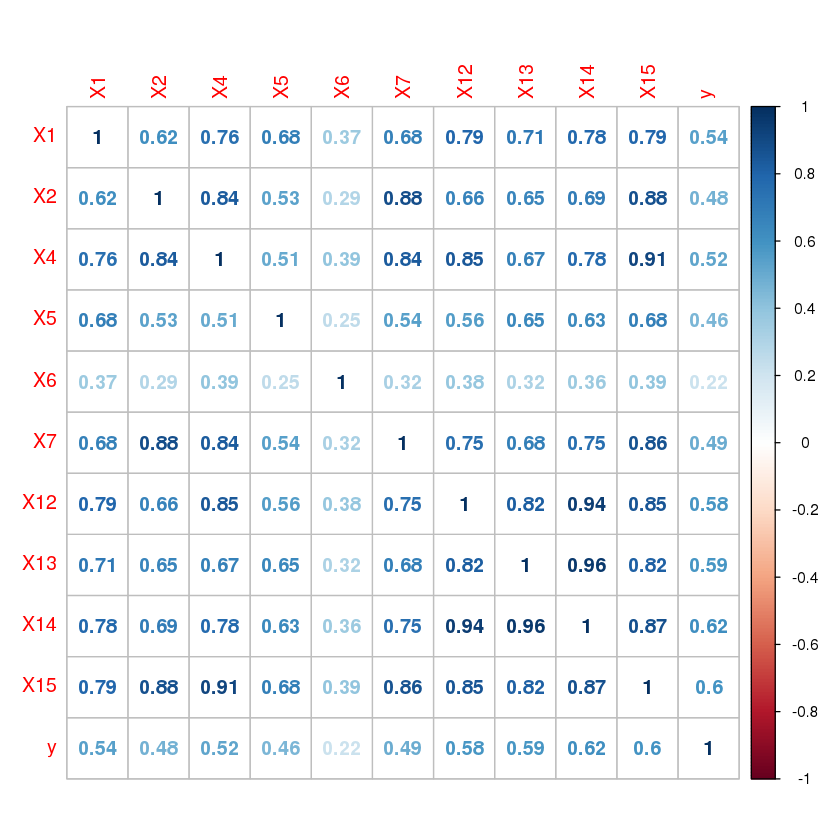

In [7]:
X$X9 = NULL
X$X10 = NULL
X$X11 = NULL
X$X6 = - X$X6
X$X3 = NULL
X$X8 = NULL
X['X13'] = -1/(X['X12'])
X['X14'] = log(X['X12'] + 0.1)
X['X15'] = log(X['X4']+15)
data = data.frame(X, y)
correlation = cor(data)
corrplot(correlation, method="number")

In [8]:
(formula = as.formula(paste("y_train ~ ", paste(names(X), collapse= "+"))))

y_train ~ X1 + X2 + X4 + X5 + X6 + X7 + X12 + X13 + X14 + X15

In [9]:
X = as.matrix(X)
X_raw = as.matrix(X_raw)

In [10]:
trainIndex <- createDataPartition(y, p = .8, 
                                  list = F, 
                                  times = 1)
X_train = X[trainIndex,]
X_test = X[-trainIndex,]
y_train = y[trainIndex]
y_test = y[-trainIndex]

In [11]:
accuracy <- function(y_true, y_pred) {
    true = 0
    for (i in 1:length(y_pred)) {
        if (y_pred[i] == y_true[i]) {
            true = true + 1
        }
    }
    return (true / length(y_pred))
}


get_results <- function(y_true, y_pred) {
    print(paste('accuracy      ', accuracy(y_true, y_pred)))
    zero_error = table(y_true, y_pred)[2,1] / table(y_true, y_pred)[1,1]
    one_error = table(y_true, y_pred)[1,2]/table(y_true, y_pred)[2,2]
    error_uniform = 1/2*zero_error + 1/2*one_error
    f_score = F1_Score(y_pred=y_pred, y_true=y_true, positive=1)
    auc = AUC(y_pred=y_pred, y_true=y_true)
    print(paste('zero class error', zero_error))
    print(paste('one class error ', one_error))
    print(paste('error uniform   ', error_uniform))
    print(paste('accuracy uniform', 1 - error_uniform))
    print(paste('f score', f_score))
    print(paste('auc', auc))
}

get_summary <- function(y_tests, predictions, model_name) {
    #predictions = apply(predictions, 2, round)
    accuracy_score = c()
    accuracy_uniform = c()
    f_score = c()
    auc = c()
    for (i in 1:NROW(predictions)) {
        accuracy_score[i] = accuracy(y_true=y_tests[i,], y_pred=predictions[i, ])
        t = table(y_tests[i,], predictions[i, ])
        zero_error = t[2,1] / t[1,1]
        one_error = t[1,2] / t[2,2]
        error_uniform = 1/2*zero_error + 1/2*one_error
        accuracy_uniform[i] = 1 - error_uniform
        f_score[i] = F1_Score(y_pred=predictions[i, ], y_true=y_tests[i,], positive=1)
        auc[i] = AUC(y_pred=predictions[i, ], y_true=y_tests[i,])
    }
    avg_acc = mean(accuracy_score)
    sd_acc = sd(accuracy_score)
    avg_un_acc = mean(accuracy_uniform)
    sd_un_acc = sd(accuracy_uniform)
    avg_f_score = mean(f_score)
    sd_f_score = sd(f_score)
    avg_auc = mean(auc)
    sd_auc = sd(auc)
    
    cat('\n')
    cat(model_name)
    cat('\n')
    #print(paste('average accuracy: ', avg_acc))
    #print(paste('sd accuracy: ', sd_acc))
    #cat('\n')
    #print(paste('average f score: ', avg_f_score))
    #print(paste('sd f score: ', sd_f_score))
    #cat('\n')
    print(paste('average auc: ', avg_auc))
    print(paste('sd auc: ', sd_auc))
}

In [12]:
# n_iter - Количество различных разбиений  на обучающую / тестовую выборки
n_iter = 30
trainIndex <- createDataPartition(y, p = 0.8, 
                              list = FALSE, 
                              times = n_iter)

y_tests = matrix(0, n_iter, length(y[-trainIndex[,1]]))
for (i in (1:n_iter)){
    y_tests[i,] = y[-trainIndex[,i]]
}

y_trains =  matrix(0, n_iter, length(y[trainIndex[,1]]))
for (i in (1:n_iter)){
    y_trains[i,] = y[trainIndex[,i]]
}

# xgb

In [13]:
predictions.xgb = matrix(0, n_iter, length(y[-trainIndex[,1]]))
predictions_train.xgb = matrix(0, n_iter, length(y[trainIndex[,1]]))

for (i in (1:n_iter)){
    X_train = X[trainIndex[,i],]
    X_test = X[-trainIndex[,i],]
    y_train = y[trainIndex[,i]]
    y_test = y[-trainIndex[,i]]
    
  xgb <- xgboost(data = X_train, verbose = 0,
     label = y_train,
     eta = 0.05,
     max_depth = 3, 
     nround=300, 
     subsample = 0.7,
     colsample_bytree = 0.7,
     eval_metric = "error",
     objective = "binary:logistic",
     nthread = 3,
    )
  y_pred = predict(xgb, X_test)
  predictions_train.xgb[i,] = sapply(predict(xgb, X_train), round)
  predictions.xgb[i,] = sapply(y_pred, round)
}

In [14]:
get_summary(y_trains, predictions_train.xgb, 'xgboost train')


xgboost train
[1] "average auc:  0.779036943768913"
[1] "sd auc:  0.00217511255190772"


In [15]:
get_summary(y_tests, predictions.xgb, 'xgboost test')


xgboost test
[1] "average auc:  0.771211709044446"
[1] "sd auc:  0.00686381839272761"


# Random forest

In [16]:
predictions.rf = matrix(0, n_iter, length(y[-trainIndex[,1]]))
predictions_train.rf = matrix(0, n_iter, length(y[trainIndex[,1]]))

for (i in (1:n_iter)){
    X_train = X[trainIndex[,i],]
    X_test = X[-trainIndex[,i],]
    y_train = y[trainIndex[,i]]
    y_test = y[-trainIndex[,i]]
    
    rf <- randomForest(x = X_train, y=as.factor(y_train), method='class', ntree=100, mtry = 3, maxnodes=10)
    y_pred = predict(rf, X_test)
    predictions_train.rf[i,] = predict(rf, X_train)
    predictions.rf[i,] = y_pred
}


In [17]:
get_summary(y_trains, predictions_train.rf, 'Random Forest train')


Random Forest train
[1] "average auc:  0.770402223344136"
[1] "sd auc:  0.00362088922195816"


In [18]:
get_summary(y_tests, predictions.rf, 'Random Forest test')


Random Forest test
[1] "average auc:  0.766672733190121"
[1] "sd auc:  0.00667165654511952"


# LR

In [19]:
predictions.lr = matrix(0, n_iter, length(y[-trainIndex[,1]]))
predictions_train.lr = matrix(0, n_iter, length(y[trainIndex[,1]]))
for (i in (1:n_iter)){
    X_train = X[trainIndex[,i],]
    X_test = X[-trainIndex[,i],]
    y_train = y[trainIndex[,i]]
    y_test = y[-trainIndex[,i]]
    
    LR = glmnet(X_train, y_train, standardize=T, )
    y_pred = sapply(predict(LR, newx=X_test, s=c(0.004)), round)
    predictions_train.lr[i, ] = sapply(predict(LR, newx=X_train, s=c(0.004)), round)
    predictions.lr[i,] = y_pred
}


In [20]:
get_summary(y_tests, predictions.lr, 'Logistic Regression train')


Logistic Regression train
[1] "average auc:  0.762089427249165"
[1] "sd auc:  0.00667169421902731"


In [21]:
get_summary(y_tests, predictions.lr, 'Logistic Regression test')


Logistic Regression test
[1] "average auc:  0.762089427249165"
[1] "sd auc:  0.00667169421902731"


# CART

In [22]:
predictions.cart = matrix(0, n_iter, length(y[-trainIndex[,1]]))
predictions_train.cart = matrix(0, n_iter, length(y[trainIndex[,1]]))

for (i in (1:n_iter)){
    X_train = X[trainIndex[,i],]
    X_test = X[-trainIndex[,i],]
    y_train = y[trainIndex[,i]]
    y_test = y[-trainIndex[,i]]
    
    data_train = data.frame(X_train, y_train)
    data_test = data.frame(X_test, y_test)
    
    cart  = rpart(formula, data=data_train, )
    y_pred = sapply(predict(cart,newdata = data_test, type = 'vector'), round)
    predictions_train.cart[i,] = sapply(predict(cart,newdata = data_train, type = 'vector'), round)
    predictions.cart[i,] = y_pred
}


In [23]:
get_summary(y_trains, predictions_train.cart, 'Cart train')


Cart train
[1] "average auc:  0.785022665663571"
[1] "sd auc:  0.0243801830178143"


In [24]:
get_summary(y_tests, predictions.cart, 'Cart test')


Cart test
[1] "average auc:  0.783193317573125"
[1] "sd auc:  0.02562995229714"


# Отчет

Удаление сильно коррелируемых между собой признаков и добавление новых, значительно увеличили результат логистической регрессии (~5%). На остальные алгоритмы это почти не повлияло (~1%). 

Из 4 моделей наилучший результат получился у XGB. Не смотря на то, что Cart достиг примерно такого же результата, среднее отклонение точности у этой модели намного больше, чем у XGB. 
В целях препятствования переобучению у модели XGB была взята небольшая глубина каждого дерева (max_depth), для каждого дерева было взято подмножество исходного датасета (subsample и colsample_bytree), было подобрано оптимальное количество циклов обучения (num_round).

Попытки объединять результаты моделей (брать среднее, минимум, максимум предстказаний моделей) не привели к увеличению точности.